## Libraries

In [1]:
#from ultralytics.data.dataset import YOLODataset
from torch.utils.data import DataLoader
from ultralytics import YOLO
import torch
import torch.nn.functional as F
import torch.nn as nn
#from ultralytics.utils.loss import v8DetectionLoss
from torchvision.ops import box_iou
from torch.optim import Adam
from torch.optim import AdamW
from torch.optim import RMSprop
from torch.optim import SGD
from torch.optim import Rprop
from torch.optim import NAdam
from torch.optim import Adam

from ultralytics.data.dataset import YOLODataset
from ultralytics.utils.ops import non_max_suppression
import matplotlib.pyplot as plt
import numpy as np


from metrics import _ECE_criterion , BrierScore , SoftBinnedECELoss, ClassificationMetrics


## Create a validation data 

In [2]:
from loaddata import create_validation_loader


valid_loader = create_validation_loader(["serbeco/images/val"], 
    batch_size=1)

valFast image access ✅ (ping: 0.0±0.0 ms, read: 2092.4±1502.1 MB/s, size: 512.1 KB)


valScanning serbeco/labels/val.cache... 388 images, 17 backgrounds, 0 corrupt: 100%|██████████| 388/388 [00:00<?, ?it/s]

valserbeco/images/val/Serbeco_run_1_part3_2024-09-16_10-09-51-453765_colorframe_9990.png: 1 duplicate labels removed
valserbeco/images/val/Serbeco_run_6_2024-07-11_11-10-44-826184frame_3270.png: 1 duplicate labels removed


In [3]:
model = YOLO('weights/yolov9t.pt')

a = next(iter(valid_loader))
result = a['img'] / 255


result =result.to(torch.float32)


result = model.model(result)



result[0][0][25:540 , :]



/home/omid/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


tensor([[-15.6761, -15.7676, -15.9324,  ..., -13.9077, -13.8434, -13.8434],
        [-15.6205, -15.7571, -15.8057,  ..., -14.0350, -14.0474, -14.0792],
        [-16.0713, -16.0285, -16.1124,  ..., -14.5610, -14.3672, -14.3477],
        ...,
        [-16.0370, -16.1114, -16.3936,  ..., -12.7945, -12.6384, -12.7389],
        [-15.9854, -16.3574, -16.3934,  ..., -12.9898, -12.9704, -13.1611],
        [-15.4168, -16.0040, -15.8158,  ..., -12.8207, -12.8541, -13.0415]])

In [9]:
bbox = result[0][:, :4, :]  # Bounding box coordinates

result_sigmoid = torch.sigmoid(result[0][:, 4:14, :])

combined = torch.cat((bbox, result_sigmoid), dim=1)

combined.shape



torch.Size([1, 14, 8400])

In [10]:
non = non_max_suppression(combined, conf_thres=0.25, iou_thres=0.45, classes=None, nc = 10 , agnostic=False, max_det=300 , in_place=False , return_idxs= True)

non[0][0][: , :4]# Bounding box coordinates of the first detection



tensor([[2.6863e-01, 1.3796e+02, 1.3764e+02, 3.5983e+02]])

## YOLO with tempreture implementation 

In [39]:

# Create a wrapper class for temperature scaling
class YOLOWithTemperature(nn.Module):
    def __init__(self, original_model):
        super(YOLOWithTemperature, self).__init__()
        self.model = original_model.model
        self.temperature = nn.Parameter(torch.ones(1) )
        
        


    def forward(self, input):
        # Get model outputs

        # Process each output head
        
      
        input = input.to(torch.float32)
        
        outputs = self.model(input)
        
        outputs = outputs[0][0].transpose(-1, -2)
        
        
      
        box_obj = outputs[..., :4]  # x, y, w, h,  , shape (N ,4)
        logits = outputs[..., 4:14]  # class logits (indices 5-14) , shape (N , 10)
        masks = outputs[... , 15:]
        #print('logits is : ',logits.shape)
            # Apply temperature scaling to class logits

        

        scaled_output = self.temperature_scale(logits)   # shape (N , 10) - temperature scaled logits
        #print('scaled output is : ',scaled_output.shape)
        # Recombine objectness and temperature scaled logits

        scaled_outputs = torch.cat((box_obj, scaled_output , masks), dim=-1)

        
            
        return scaled_outputs


    
    def temperature_scale(self, logits):

        tempreture = self.temperature.unsqueeze(0).expand(logits.shape[0],  logits.shape[1]  )
        return logits / tempreture



   


    def sharpness_of_model( self , logits):
        scaled_logits = self.temperature_scale(logits)

        print('scaled logits is : ',scaled_logits.shape)
        probs = torch.nn.functional.sigmoid(scaled_logits) # shape (N , 10)

        print('probs is : ',probs.shape)
        max_probs  = torch.max(probs , dim=-1)[0] # shape (N , )
        return torch.mean(max_probs).item()
    

    
    def confidence_entropy(self, logits):
        # Apply temperature scaling to logits
        scaled_logits = self.temperature_scale(logits)
        
        # Compute confidence scores using sigmoid
        probs = torch.nn.functional.sigmoid(scaled_logits)  # Shape: (N,) or (N, ...)
        
        # Ensure probs is 1D for simplicity (flatten if needed)
        probs = probs.view(-1)
        
        # Compute entropy for each confidence score
        # Treat each confidence score as a binary distribution: [prob, 1-prob]
        entropy = - (probs * torch.log2(probs + 1e-10) + (1 - probs) * torch.log2(1 - probs + 1e-10))
        
        # Average entropy across all predictions
        avg_entropy = torch.mean(entropy).item()
        
        return avg_entropy
    

    def compare_with_original_model(self , valid_loader   ):

        all_logits = []
        all_labels =[]

        

        with torch.no_grad():

            self.temperature.data = torch.tensor([1.0] , device = self.temperature.device , dtype = torch.float32)
            for batch in valid_loader:
                img = batch['img'] /255.0

                
                outputs = self.forward(img)


                targets = {
                    'cls' : batch['cls'] , 
                    'bboxes' : batch['bboxes'] , 
                    'batch_idx' : batch['batch_idx']
                }

                logits , labels = self._match_targets_to_outputs(outputs , targets)

                if logits is not None and labels is not None:
                    all_logits.append(logits)
                    all_labels.append(labels)

        all_logits = torch.cat(all_logits , dim = 0)
        all_labels = torch.cat(all_labels , dim = 0).long()


        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECE_criterion().cuda()
        brier_criterion = BrierScore().cuda()

        nll = nll_criterion(all_logits , all_labels.squeeze(1)).item()
        ece = ece_criterion(all_logits , all_labels.squeeze(1)).item()
        brier = brier_criterion(all_logits , all_labels.squeeze(1)).item()

        print('all_logits shape is : ',all_logits.shape)
        print('all_labels shape is : ',all_labels.squeeze(1).shape)

        print(f'NLL: {nll:.3f}, ECE: {ece:.3f} , Brier Score: {brier:.3f}')
        print('entropy of the temperature scaled model is : ',self.confidence_entropy(all_logits))

        return nll , ece , brier 

    def test_with_different_temperature(self , valid_loader):
        
        
        all_logits = []
        all_labels =[]
    
        
        self.temperature.data = torch.tensor(1.0, device=self.temperature.device)
        with torch.no_grad():

            
            for batch in valid_loader:
                # Extract and prepare input image

                
                img = batch['img'].to(torch.float32) / 255.0  # Shape: (1, 3, 640, 640)
                
                
                
                # Get model outputs through forward function to apply temperature scaling
                
                
                outputs = self.forward(img)
                
            
            
                
            

                

                # Extract targets
                targets = {
                    'cls': batch['cls'],
                    'bboxes': batch['bboxes'],
                    'batch_idx': batch['batch_idx']
                    }
                
                # Collect logits and labels
                logits, labels = self._match_targets_to_outputs(outputs, targets)


                if logits is not None and labels is not None:

                    all_logits.append(logits)
                    
                    all_labels.append(labels)
            
        all_logits = torch.cat(all_logits , dim = 0)
        all_labels = torch.cat(all_labels , dim = 0).long()

        print(f"colelcted {len(all_logits)} logits and {len(all_labels)} labels")


        
        nll_criterion  = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECE_criterion().cuda()

        temps = [1,2.089 , 2.5 , 3 , 4  , 6,7 , 8 , 9 , 9.5, 10 , 15,20 , 30 , 40 , 50 , 60 , 70 , 80 , 90 , 100]

        print('testing with different temperatures')

        results = []
        for temp in temps:
            
            self.temperature.data = torch.tensor(temp,dtype = torch.float32, device=self.temperature.device)
            temperature_nll = nll_criterion(self.temperature_scale(all_logits), all_labels.squeeze(1)).item()
            temperature_ece = ece_criterion(self.temperature_scale(all_logits), all_labels.squeeze(1)).item()
            
            print(f'temp is' , self.temperature.item())
            

            results.append({'temperature': temp, 'NLL': temperature_nll, 'ECE': temperature_ece})

            print(f'temperature {temp} - NLL: {temperature_nll :.3f}, ECE: {temperature_ece :.3f}')
            print('for cheking the shaprpness of the temperature scaling , the average max probablity is : ',self.sharpness_of_model(all_logits))
            print('entropy of the temperature scaled model is : ',self.confidence_entropy(all_logits))
        return results

    def set_temperature(self, valid_loader):
        all_logits = []
        all_labels = []

        with torch.no_grad():
            for batch in valid_loader:
                img = batch['img'] / 255.0
                outputs = self.forward(img)
                targets = {
                    'cls': batch['cls'],
                    'bboxes': batch['bboxes'],
                    'batch_idx': batch['batch_idx']
                }
                logits, labels = self._match_targets_to_outputs(outputs, targets)
                if logits is not None and labels is not None:
                    all_logits.append(logits)
                    all_labels.append(labels)

        all_logits = torch.cat(all_logits, dim=0)
        all_labels = torch.cat(all_labels, dim=0).long()

        print('all_logits shape:', all_logits.shape)
        print('all_labels shape:', all_labels.shape)

        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_diff_loss = SoftBinnedECELoss()  # Assume fixed soft_bin_temp
        ece_criterion = _ECE_criterion().cuda()
        brier_criterion = BrierScore()

        # Compute baseline metrics
        before_temperature_nll = nll_criterion(all_logits, all_labels.squeeze(1)).item()
        before_temperature_ece_diff = ece_diff_loss(all_logits, all_labels.squeeze(1)).item()
        before_temperature_ece = ece_criterion(all_logits, all_labels.squeeze(1)).item()
        before_temperature_brier = brier_criterion(all_logits, all_labels.squeeze(1)).item()

        # plot the ece before tempreture 
        ece_criterion.plot_reliability_diagram()

        print(f'Before temperature - NLL: {before_temperature_nll:.3f}, ECE: {before_temperature_ece:.3f}')
        print(f'Before temperature - ECE Diff: {before_temperature_ece_diff:.3f}')
        print(f'Before temperature - ECE : ' , before_temperature_ece)
        print(f'Before temperature - Brier Score: {before_temperature_brier:.3f}')
        # Grid search over learning rates
        learning_rates = [0.01, 0.05, 0.1, 0.15 ,0.17 ,0.175, 0.18 ,0.185, 0.19,0.2]
        
        best_lr = None
        best_ece = float('inf')
        best_temperature = None
        best_inside_temp = None
        best_scaled_logits = None

        for lr in learning_rates:
            # Reset parameters to initial values
            self.temperature.data = torch.tensor([1.0] , dtype=torch.float32)  # Reset temperature
            ece_diff_loss.inside_temp.data = torch.tensor([1] , dtype=torch.float32)  # Reset soft binning temp

            # Set up optimizer with current learning rate
            optimizer = torch.optim.Adam(params=[self.temperature, ece_diff_loss.inside_temp], lr=lr)

            def eval():
                optimizer.zero_grad()
                scaled_logits = self.temperature_scale(all_logits)  # Assume logits / self.temperature
                loss = ece_diff_loss(scaled_logits, all_labels.squeeze(1))
                loss.backward()
                return loss

            # Perform optimization step
            optimizer.step(eval)

            # Compute ECE after optimization
            with torch.no_grad():
                scaled_logits = self.temperature_scale(all_logits)
                current_ece = ece_criterion(scaled_logits, all_labels.squeeze(1)).item()
                current_ece_diff = ece_diff_loss(scaled_logits, all_labels.squeeze(1)).item()
            print(f'LR: {lr:.4f}, Temperature: {self.temperature.item():.3f}, Inside Temp: {ece_diff_loss.inside_temp.item():.3f}, ECE Diff: {current_ece_diff:.3f}, ECE: {current_ece:.3f}')

            # Update best learning rate if current ECE is lower
            if current_ece < best_ece:
                best_ece = current_ece
                best_lr = lr
                best_temperature = self.temperature.clone().detach()
                best_inside_temp = ece_diff_loss.inside_temp.clone().detach()
                best_scaled_logits = scaled_logits.clone().detach()

        # Set final parameters to best values
        self.temperature.data = best_temperature
        ece_diff_loss.inside_temp.data = best_inside_temp

        print(f"Best learning rate: {best_lr:.4f}")
        print(f"Optimized temperature: {self.temperature.item():.3f}")
        print(f"Optimized inside temp: {ece_diff_loss.inside_temp.item():.3f}")

        # Compute final metrics
        after_temperature_nll = nll_criterion(best_scaled_logits, all_labels.squeeze(1)).item()
        after_temperature_ece = ece_criterion(best_scaled_logits, all_labels.squeeze(1)).item()
        after_temperature_ece_diff = ece_diff_loss(best_scaled_logits, all_labels.squeeze(1)).item()
        after_temperature_brier = brier_criterion(best_scaled_logits, all_labels.squeeze(1)).item()

        print(f'Optimal temperature: {self.temperature.item():.3f}')
        print(f'After temperature - NLL: {after_temperature_nll:.3f}, ECE: {after_temperature_ece:.3f}')
        print(f'Improvement in ECE in percent: {((before_temperature_ece - after_temperature_ece) / before_temperature_ece) * 100:.2f}%')
        print(f'For checking the sharpness of the temperature scaling, the average max probability is: {self.sharpness_of_model(all_logits):.3f}')
        print(f'After temperature - ECE Diffrentiable : {after_temperature_ece_diff:.3f}')
        print(f'after temperature - Brier Score: {after_temperature_brier:.3f}')

        # Plot reliability diagram after temperature scaling
        ece_criterion.plot_reliability_diagram()



        # Compute classification metrics before and after scaling
        metrics = ClassificationMetrics(num_classes=10)
        precision_before, recall_before = metrics.compute_precision_recall(all_logits, all_labels)
        fpr_before, tpr_before, auc_before = metrics.compute_roc_curve(all_logits, all_labels)
        precision_after, recall_after = metrics.compute_precision_recall(best_scaled_logits, all_labels)
        fpr_after, tpr_after, auc_after = metrics.compute_roc_curve(best_scaled_logits, all_labels)

        print(f'\nClassification Metrics:')
        print(f'Before scaling - Precision: {precision_before:.3f}, Recall: {recall_before:.3f}, ROC AUC: {auc_before:.3f}')
        print(f'After scaling - Precision: {precision_after:.3f}, Recall: {recall_after:.3f}, ROC AUC: {auc_after:.3f}')

        # Plot ROC curves
        
        plt.figure()
        plt.plot(fpr_before, tpr_before, label=f'Before scaling (AUC = {auc_before:.3f})')
        plt.plot(fpr_after, tpr_after, label=f'After scaling (AUC = {auc_after:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison')
        plt.legend()
        plt.show()


        precision_per_class , recall_per_class = metrics.compute_per_class_precision_recall(best_scaled_logits, all_labels)

        # Print per-class metrics
        print("\nPer-class Precision and Recall:")
        # Plot per-class precision and recall bar chart
        class_names = ['Metal', 'Plastic', 'Glass', 'Cardboard', 'Paper', 'Organic', 'Wood', 'e-Waste', 'Rubble', 'Fabric']
        fig, ax = plt.subplots(figsize=(12, 6))
        bar_width = 0.35
        x = np.arange(len(class_names))
        ax.bar(x - bar_width/2, precision_per_class, bar_width, label='Precision', color='red')
        ax.bar(x + bar_width/2, recall_per_class, bar_width, label='Recall', color='blue')
        ax.set_xlabel('Class')
        ax.set_ylabel('Score')
        ax.set_title('Per-class Precision and Recall')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45)
        ax.legend()
        plt.tight_layout()
        plt.show()


        # avegaraged precision and recall and MAP

        ap_per_class = metrics.compute_ap_per_class(all_logits, all_labels)

        ap_per_class_after_temp = metrics.compute_ap_per_class(best_scaled_logits, all_labels)

        fig , ax = plt.subplots(figsize=(12, 6))
        bar_width = 0.35
        x = np.arange(len(class_names))
        ax.bar(x - bar_width/2, list(ap_per_class.values()), bar_width, label='AP Before Temp', color='red')
        ax.bar(x + bar_width/2, list(ap_per_class_after_temp.values()), bar_width , label='AP After Temp', color='blue')
        ax.set_xlabel('Class')
        ax.set_ylabel('Average Precision')
        ax.set_title('Average Precision per Class Before and After Temperature Scaling')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45)
        ax.legend()
        plt.tight_layout()
        plt.show()


        mean_ap_before = metrics.compute_map(ap_per_class)
        mean_ap_after = metrics.compute_map(ap_per_class_after_temp)
        print(f'Mean Average Precision Before Temperature Scaling: {mean_ap_before:.3f}')
        print(f'Mean Average Precision After Temperature Scaling: {mean_ap_after:.3f}')
        
        return self




    def _match_targets_to_outputs(self, outputs, targets):  # for each image 
        
        labels = []
        logits  = []
    

        logits_for_nms = outputs.clone()  # Clone to avoid modifying original logits
        logits_for_nms = logits_for_nms.unsqueeze(0).transpose(-1, -2)  # Add batch dimension and transpose to match expected shape
        confidence = torch.sigmoid(logits_for_nms[: , 4:14 , :]  )
        bbox = logits_for_nms[: , 0:4 , :]   # Extract bounding box coordinates (x, y, x, y)
        combined = torch.cat((bbox , confidence) , dim = 1)  # Remove batch dimension if present

        nms_detections = non_max_suppression(combined, conf_thres=0.5,nc = 10, iou_thres=0.45, classes=None, agnostic=False, max_det=300 , in_place=False , return_idxs=True)

      

        original_indices = nms_detections[1][0] # Get the original indices of detections before NMS
        

        if len(nms_detections[0][0]) == 0:
            return None, None
            
        pred_bboxes_xyxy = nms_detections[0][0][..., :4]  # Extract bounding boxes (x, y,x, y)
        targets_bboxes = targets['bboxes']   #[N , 4]

        targets_bboxes_xyxy = torch.cat([targets_bboxes[: , :2]- targets_bboxes[: , 2:4]/2 , targets_bboxes[: , :2]+ targets_bboxes[: , 2:4]/2], dim = 1)
        
        image_height, image_width = 640, 640  # Replace with your image size
        # Normalize bounding boxes to [0, 1] range
        pred_bboxes_xyxy[:, 0] /= image_width   # Normalize x
        pred_bboxes_xyxy[:, 1] /= image_height  # Normalize y
        
        pred_bboxes_xyxy[:, 2] /= image_width   # Normalize x2
        pred_bboxes_xyxy[:, 3] /= image_height  # Normalize y2
        
      
        

        iou_matrix = box_iou(targets_bboxes_xyxy, pred_bboxes_xyxy)   # N , M
        
       
        
        max_iou, max_iou_index = torch.max(iou_matrix , dim = 1)   # shape (N , )  # which detection index in nms has the maximum iou with each target
        
        
        num_classes = 10 
        for i in range(len(max_iou_index)):

            original_detection_idx = original_indices[max_iou_index[i]]
            
            if iou_matrix[i , max_iou_index[i]] > 0.45:
               
                labels.append(targets['cls'][i])
                
                 # Use the original index to get logits from the original outputs
                
                
              # Append the logits for the target class
            else:
                labels.append(torch.tensor(10))  # Append a dummy class index for unmatched targets

            logits.append(outputs[original_detection_idx , 4:14])

        print(f"Number of matched logits: {len(logits)}")
        print(f"Number of matched labels: {len(labels)}")
        if len(logits) == 0:
            
            return None, None 
        

        logits= torch.stack(logits , dim = 0) if len(logits)>0 else None
        labels= torch.stack(labels , dim = 0) if len(labels)>0 else None        
        
            
        return logits  , labels


   



    

Number of matched logits: 11
Number of matched labels: 11
Number of matched logits: 9
Number of matched labels: 9
Number of matched logits: 22
Number of matched labels: 22
Number of matched logits: 13
Number of matched labels: 13
Number of matched logits: 16
Number of matched labels: 16
Number of matched logits: 21
Number of matched labels: 21
Number of matched logits: 31
Number of matched labels: 31
Number of matched logits: 32
Number of matched labels: 32
Number of matched logits: 43
Number of matched labels: 43
Number of matched logits: 39
Number of matched labels: 39
Number of matched logits: 7
Number of matched labels: 7
Number of matched logits: 6
Number of matched labels: 6
Number of matched logits: 6
Number of matched labels: 6
Number of matched logits: 3
Number of matched labels: 3
Number of matched logits: 14
Number of matched labels: 14
Number of matched logits: 16
Number of matched labels: 16
Number of matched logits: 4
Number of matched labels: 4
Number of matched logits: 

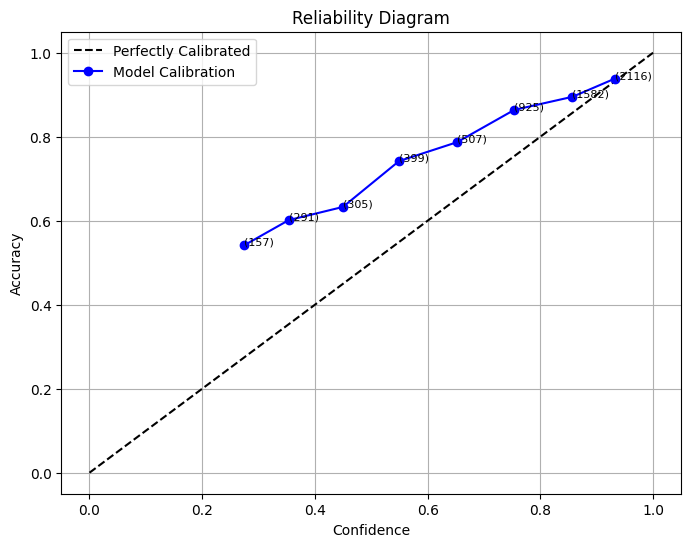

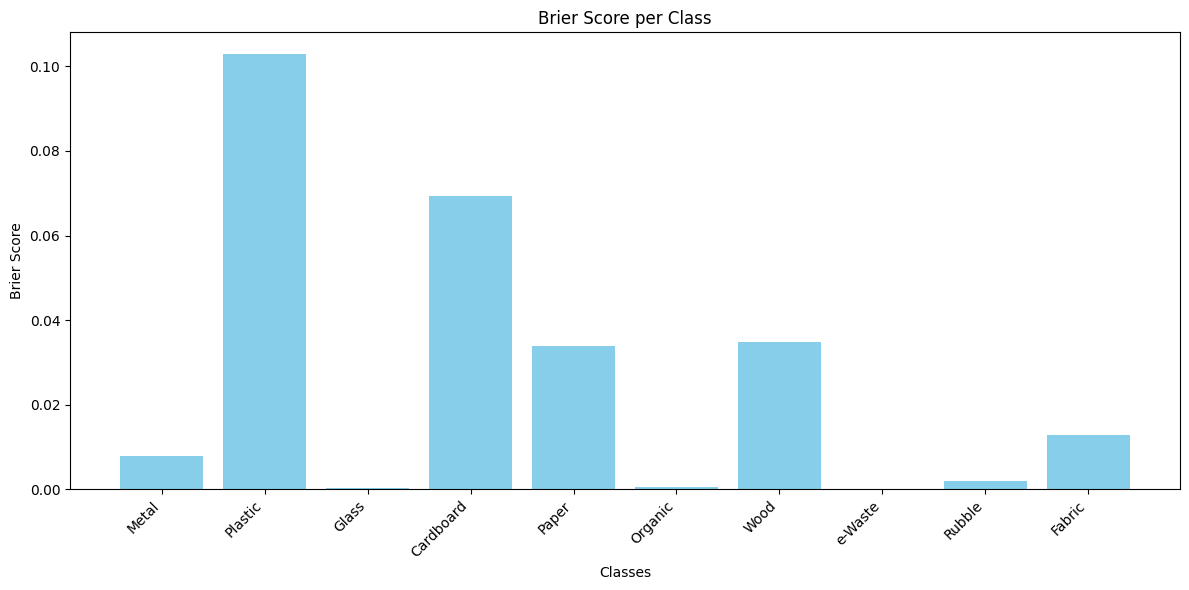

all_logits shape is :  torch.Size([6282, 10])
all_labels shape is :  torch.Size([6282])
NLL: 0.936, ECE: 0.078 , Brier Score: 0.264
entropy of the temperature scaled model is :  0.0760694295167923
for original model we have NLL: 0.936, ECE: 0.078 , brier :0.264
Number of matched logits: 11
Number of matched labels: 11
Number of matched logits: 9
Number of matched labels: 9
Number of matched logits: 23
Number of matched labels: 23
Number of matched logits: 13
Number of matched labels: 13
Number of matched logits: 16
Number of matched labels: 16
Number of matched logits: 21
Number of matched labels: 21
Number of matched logits: 35
Number of matched labels: 35
Number of matched logits: 35
Number of matched labels: 35
Number of matched logits: 44
Number of matched labels: 44
Number of matched logits: 36
Number of matched labels: 36
Number of matched logits: 7
Number of matched labels: 7
Number of matched logits: 6
Number of matched labels: 6
Number of matched logits: 6
Number of matched la

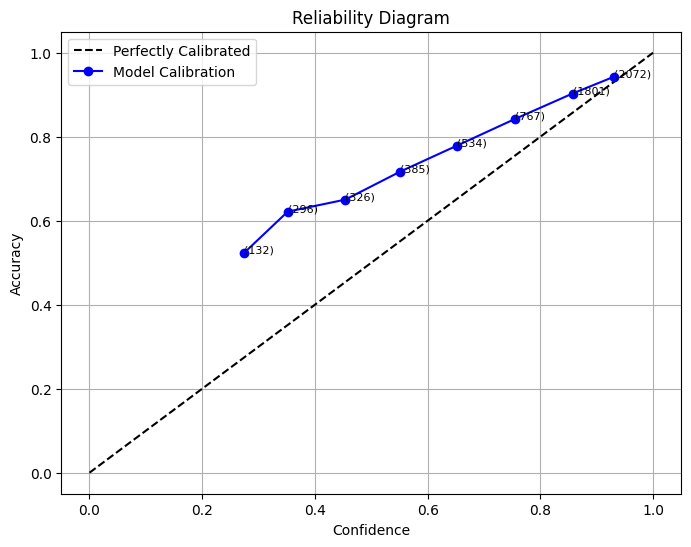

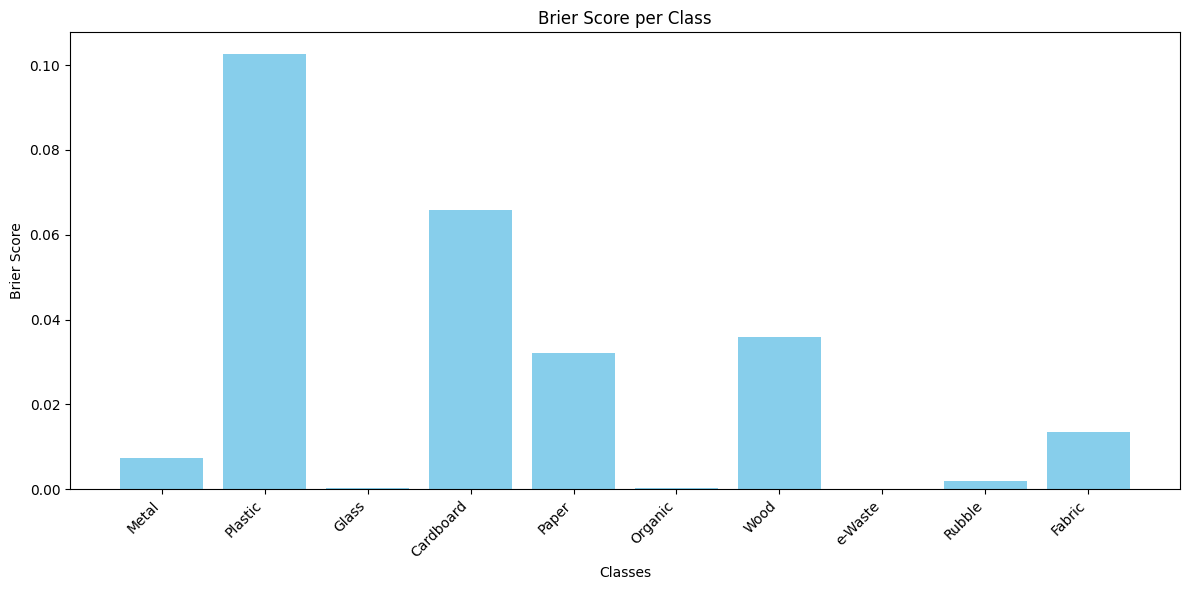

all_logits shape is :  torch.Size([6313, 10])
all_labels shape is :  torch.Size([6313])
NLL: 0.924, ECE: 0.076 , Brier Score: 0.260
entropy of the temperature scaled model is :  0.07606541365385056
for yolo v8n with AvUC loss model we have NLL: 0.924, ECE: 0.076 , brier :0.260
Number of matched logits: 10
Number of matched labels: 10
Number of matched logits: 8
Number of matched labels: 8
Number of matched logits: 20
Number of matched labels: 20
Number of matched logits: 9
Number of matched labels: 9
Number of matched logits: 12
Number of matched labels: 12
Number of matched logits: 17
Number of matched labels: 17
Number of matched logits: 30
Number of matched labels: 30
Number of matched logits: 26
Number of matched labels: 26
Number of matched logits: 34
Number of matched labels: 34
Number of matched logits: 32
Number of matched labels: 32
Number of matched logits: 7
Number of matched labels: 7
Number of matched logits: 6
Number of matched labels: 6
Number of matched logits: 6
Number

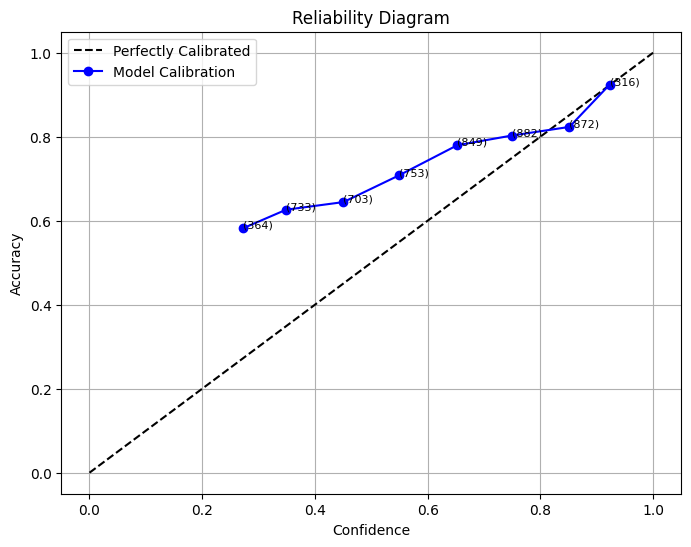

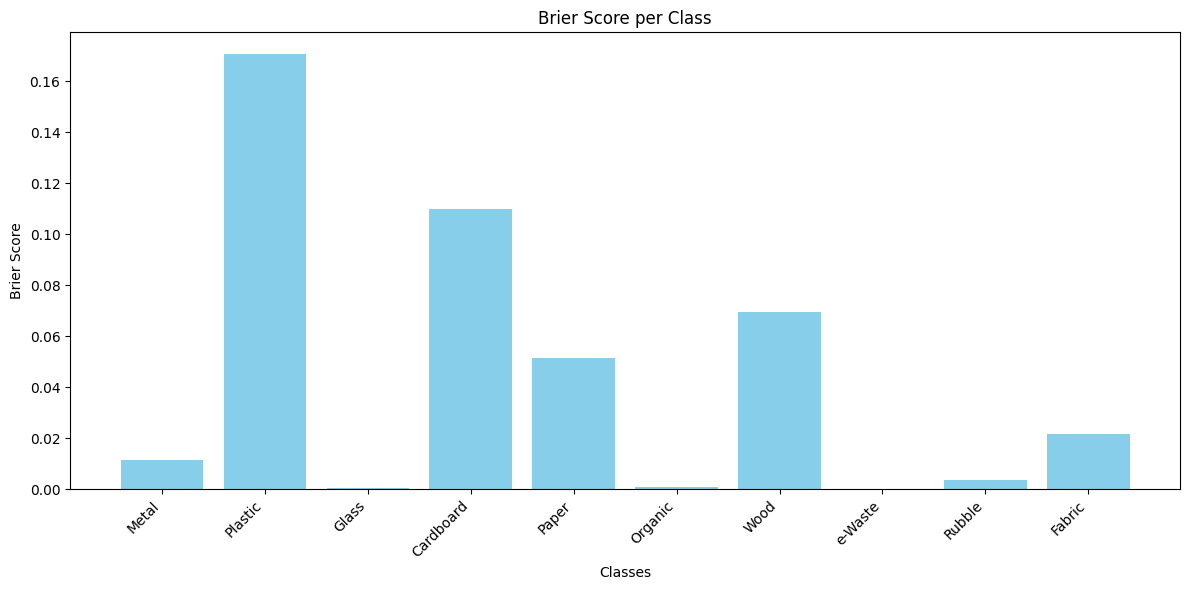

all_logits shape is :  torch.Size([5472, 10])
all_labels shape is :  torch.Size([5472])
NLL: 0.985, ECE: 0.137 , Brier Score: 0.439
entropy of the temperature scaled model is :  0.1338208168745041
for original model we have NLL: 0.985, ECE: 0.137 , brier :0.439


In [5]:
#model = YOLO('weights/best.pt')
#model1 = YOLO('weights/dropout-0.1.pt')
#model3 = YOLO('weights/best-with-dropout-layer.pt')
#model4 = YOLO('weights/best-smoothing1.pt')

model5 = YOLO('weights/yolov8n.pt')
model6 = YOLO("weights/yolov8n-AvUc.pt")
model7 = YOLO("weights/best.pt")



model5 = YOLOWithTemperature(model5)
nll5 , ece5  , brier = model5.compare_with_original_model(valid_loader)
print(f"for original model we have NLL: {nll5:.3f}, ECE: {ece5:.3f} , brier :{brier:.3f}")



model6 = YOLOWithTemperature(model6)
nll6 , ece6 , brier = model6.compare_with_original_model(valid_loader)
print(f"for yolo v8n with AvUC loss model we have NLL: {nll6:.3f}, ECE: {ece6:.3f} , brier :{brier:.3f}")


model7 = YOLOWithTemperature(model7)
nll7 , ece7 , brier = model7.compare_with_original_model(valid_loader)
print(f"for original model we have NLL: {nll7:.3f}, ECE: {ece7:.3f} , brier :{brier:.3f}")


In [40]:
model = YOLO('weights/yolov8n-AvUc.pt')

temperature_scaled_model = YOLOWithTemperature(model)
temperature_scaled_model.set_temperature(valid_loader)





/home/omid/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Number of matched logits: 16
Number of matched labels: 16


RuntimeError: stack expects each tensor to be equal size, but got [1] at entry 0 and [] at entry 1

In [9]:
model = YOLO('weights/best.pt')

model = YOLOWithTemperature(model)
model.test_with_different_temperature(valid_loader)





/home/omid/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Number of matched logits: 11
Number of matched labels: 11
Number of matched logits: 10
Number of matched labels: 10
Number of matched logits: 23
Number of matched labels: 23
Number of matched logits: 10
Number of matched labels: 10
Number of matched logits: 12
Number of matched labels: 12
Number of matched logits: 19
Number of matched labels: 19
Number of matched logits: 38
Number of matched labels: 38
Number of matched logits: 29
Number of matched labels: 29
Number of matched logits: 38
Number of matched labels: 38
Number of matched logits: 41
Number of matched labels: 41
Number of matched logits: 7
Number of matched labels: 7
Number of matched logits: 6
Number of matched labels: 6
Number of matched logits: 6
Number of matched labels: 6
Number of matched logits: 4
Number of matched labels: 4
Number of matched logits: 14
Number of matched labels: 14
Number of matched logits: 17
Number of matched labels: 17
Number of matched logits: 4
Number of matched labels: 4
Number of matched logits

[{'temperature': 1, 'NLL': 1.0298558473587036, 'ECE': 0.13788960874080658},
 {'temperature': 2.089, 'NLL': 0.8260557651519775, 'ECE': 0.1712946891784668},
 {'temperature': 2.5, 'NLL': 0.8754642009735107, 'ECE': 0.179833322763443},
 {'temperature': 3, 'NLL': 0.958897590637207, 'ECE': 0.18743455410003662},
 {'temperature': 4, 'NLL': 1.1370271444320679, 'ECE': 0.19735459983348846},
 {'temperature': 6, 'NLL': 1.4178729057312012, 'ECE': 0.20765464007854462},
 {'temperature': 7, 'NLL': 1.5186799764633179, 'ECE': 0.2106521725654602},
 {'temperature': 8, 'NLL': 1.6002684831619263, 'ECE': 0.21291305124759674},
 {'temperature': 9, 'NLL': 1.6672046184539795, 'ECE': 0.21467794477939606},
 {'temperature': 9.5, 'NLL': 1.6962825059890747, 'ECE': 0.21542271971702576},
 {'temperature': 10, 'NLL': 1.7228995561599731, 'ECE': 0.21609371900558472},
 {'temperature': 15, 'NLL': 1.9010170698165894, 'ECE': 0.22035744786262512},
 {'temperature': 20, 'NLL': 1.9959996938705444, 'ECE': 0.22249656915664673},
 {'tem